### import package

In [1]:
import wfdb.processing as wp
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import butter, lfilter  
import pandas as pd
import scipy.io as sio
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
label_path = os.path.join("preliminary", "reference.txt")
labels = pd.read_csv(label_path, sep='\t',header = None)

In [40]:
import scipy.io as sio
dataset_path = "preliminary\\\TRAIN\\"#TRAIN    
record = "TRAIN103"#TRAIN380
ecg = sio.loadmat(dataset_path+record+'.mat')
ecg['data'] = signal.resample(ecg['data'].T,2560).T

In [22]:
ecg["data"].shape #   i ii iii avr avl avf v1~v6 

(12, 2560)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


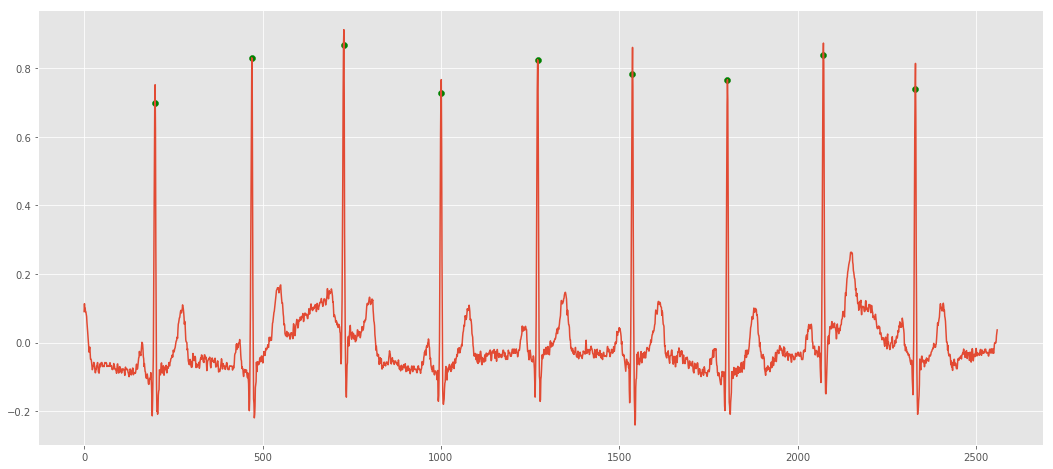

In [47]:
ecg_data = ecg["data"][0]
hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
qrs_inds = wp.xqrs_detect(ecg_data, 500)
# # print hard_peaks
plt.figure(figsize=(18,8))
plt.plot(ecg_data)
#plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
#plt.plot(soft_peaks)
plt.show()

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
labels :  [1]


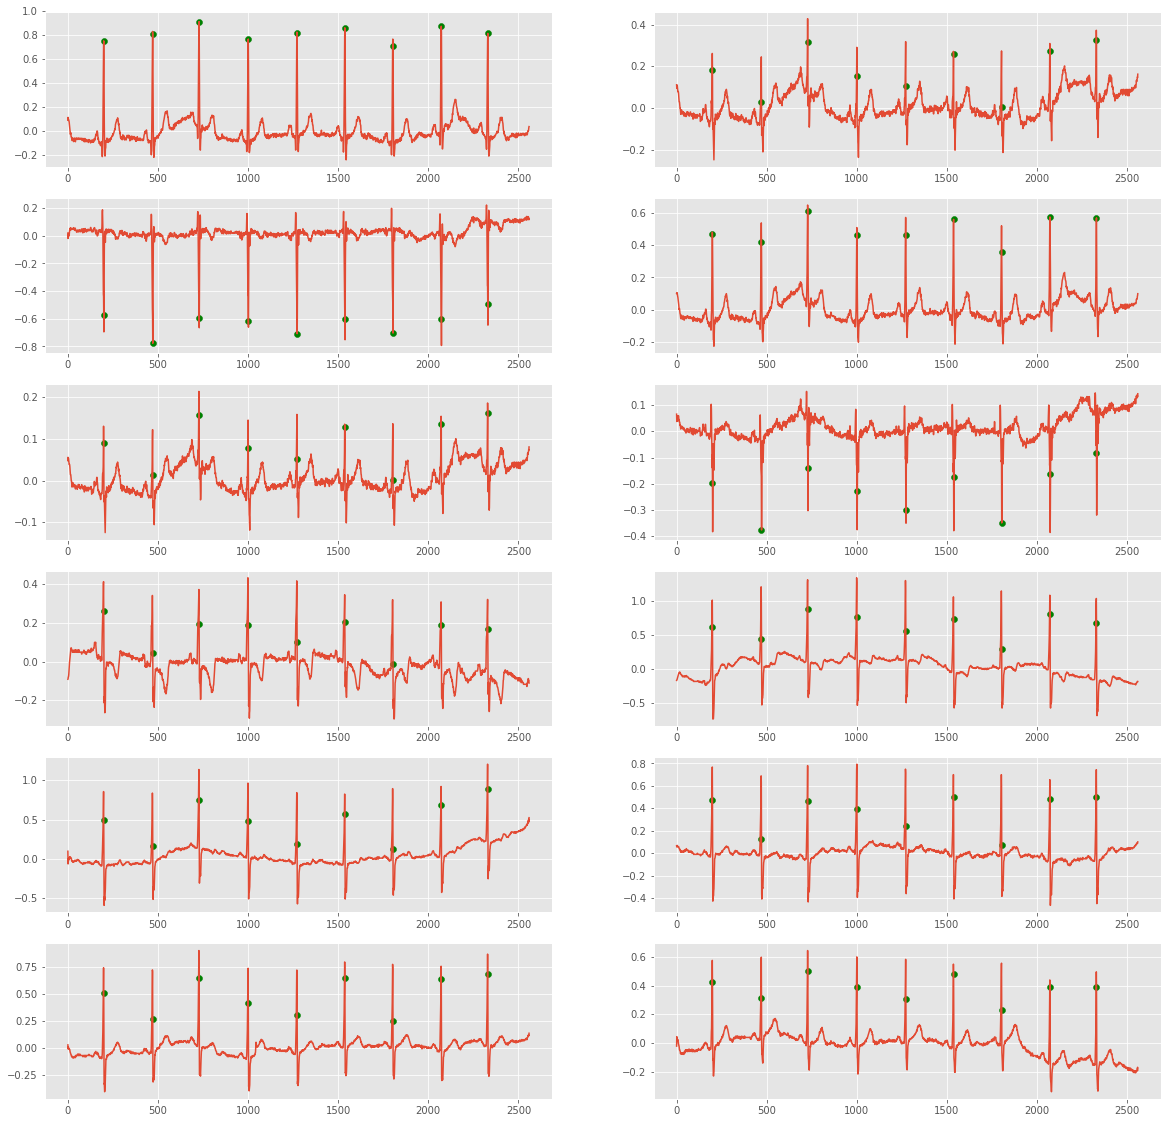

In [45]:
plt.figure(figsize=(20,20))
ecg_data = ecg["data"][2]
hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
qrs_inds = wp.xqrs_detect(ecg_data, 500)
for i in range(12):
    plt.subplot(6, 2, i+1)
    ecg_data = ecg["data"][i]
    #hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
    #qrs_inds = wp.xqrs_detect(ecg_data, 500)
    # # print hard_peaks
    #plt.figure(figsize=(18,8))
    plt.plot(ecg_data)
    #plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
    plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
#plt.plot(soft_peaks)
print("labels : ",labels[labels[0] == record][1].values)
plt.show()

In [3]:
def read_data(data_path, split = "TRAIN"):
    """ Read data """

    # Fixed params
    n_class = 2
    n_steps = 2560

    # Paths
    path_signals = os.path.join(data_path, split)

    # Read labels and one-hot encode
    label_path = os.path.join(data_path, "reference.txt")
    labels = pd.read_csv(label_path, sep='\t',header = None)

    # Read time-series data
    channel_files = os.listdir(path_signals)
    channel_files.sort()
    n_channels = 12#len(channel_files)
    #posix = len(split) + 5

    # Initiate array
    list_of_channels = []
    X = np.zeros((len(labels), n_steps, n_channels))
    i_ch = 0
    for i_ch,fil_ch in enumerate(channel_files):
        #channel_name = fil_ch[:-posix]
        #dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
        ecg = sio.loadmat(os.path.join(path_signals,fil_ch))
        ecg['data'] = signal.resample(ecg['data'].T,2560)
        X[i_ch,:,:] = ecg['data']

        # Record names
        #list_of_channels.append(channel_name)

        # iterate
        #i_ch += 1

    # Return 
    return X, labels, list_of_channels
def one_hot(labels, n_class = 2):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y
def get_batches(X, y, batch_size = 32):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [4]:
x,y,z = read_data("preliminary")

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [6]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(x, y[1].values, 
                                                stratify = y[1].values, random_state = 123)

In [7]:
X_tr.shape

(450, 2560, 12)

In [8]:
y_tr = one_hot(lab_tr)
y_vld  = one_hot(lab_vld)

In [9]:
import tensorflow as tf

In [40]:
batch_size = 32       # Batch size
seq_len = 2560#5000#128          # Number of steps
learning_rate = 0.0001
epochs =140#500#1000

n_classes = 2
n_channels = 12

In [32]:
graph = tf.Graph()
tf.reset_default_graph()
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [33]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    # (batch, 5000, 12) --> (batch, 2500, 24)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=24, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 18)
    # (batch, 2500, 24) --> (batch, 1250, 24)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=24, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=24, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
        
    
    # (batch, 32, 18) --> (batch, 16, 36)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 18) --> (batch, 16, 36)
    conv6 = tf.layers.conv1d(inputs=max_pool_4, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_6 = tf.layers.max_pooling1d(inputs=conv6, pool_size=2, strides=4, padding='same')
    
    # (batch, 16, 36) --> (batch, 8, 36)
    conv5 = tf.layers.conv1d(inputs=max_pool_6, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_5 = tf.layers.max_pooling1d(inputs=conv5, pool_size=2, strides=4, padding='same')

In [13]:
max_pool_5

<tf.Tensor 'max_pooling1d_5/Squeeze:0' shape=(?, 10, 36) dtype=float32>

In [34]:
with graph.as_default():
    
    # convolution: input to output of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_11 = tf.layers.conv1d(inputs=max_pool_5, filters=36, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_21 = tf.layers.conv1d(inputs=max_pool_5, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_31 = tf.layers.conv1d(inputs=max_pool_5, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # average pool: input to middle layer of inception
    # (batch, 8, 36) --> (batch, 8, 36)
    avg_pool_41 = tf.layers.average_pooling1d(inputs=max_pool_5, pool_size=4, strides=1, padding='same')
    
    ## Middle layer of inception
    
    # convolution: middle to out layer of inception (size=2)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv2_22 = tf.layers.conv1d(inputs=conv1_21, filters=36, kernel_size=2, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=4)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv4_32 = tf.layers.conv1d(inputs=conv1_31, filters=36, kernel_size=4, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_42 = tf.layers.conv1d(inputs=avg_pool_41, filters=36, kernel_size=1, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    ## Out layer: Concatenate filters
    # (batch, 8, 4*36)
    inception_out = tf.concat([conv1_11, conv2_22, conv4_32, conv1_42], axis=2)

In [15]:
inception_out

<tf.Tensor 'concat:0' shape=(?, 10, 144) dtype=float32>

In [35]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(inception_out, (-1, 10*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [27]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [36]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 1/500 Iteration: 5 Train loss: 0.690323 Train acc: 0.546875
Epoch: 3/500 Iteration: 10 Train loss: 0.685791 Train acc: 0.531250
Epoch: 3/500 Iteration: 10 Validation loss: 0.687181 Validation acc: 0.515625
Epoch: 4/500 Iteration: 15 Train loss: 0.688529 Train acc: 0.460938
Epoch: 6/500 Iteration: 20 Train loss: 0.667007 Train acc: 0.593750
Epoch: 6/500 Iteration: 20 Validation loss: 0.670516 Validation acc: 0.617188
Epoch: 8/500 Iteration: 25 Train loss: 0.646222 Train acc: 0.664062
Epoch: 9/500 Iteration: 30 Train loss: 0.620282 Train acc: 0.687500
Epoch: 9/500 Iteration: 30 Validation loss: 0.626101 Validation acc: 0.718750
Epoch: 11/500 Iteration: 35 Train loss: 0.570888 Train acc: 0.703125
Epoch: 13/500 Iteration: 40 Train loss: 0.509794 Train acc: 0.789062
Epoch: 13/500 Iteration: 40 Validation loss: 0.540185 Validation acc: 0.765625
Epoch: 14/500 Iteration: 45 Train loss: 0.448588 Train acc: 0.796875
Epoch: 16/500 Iteration: 50 Train loss: 0.463348 Train acc: 0.781250
Epoc

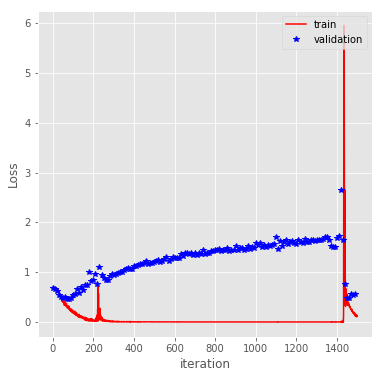

In [37]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

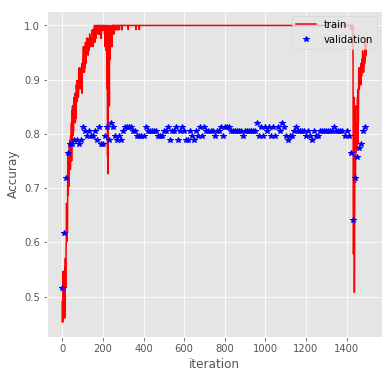

In [38]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [39]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}

        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn\har.ckpt
Test accuracy: 0.812500


In [55]:
#####################################
###SETTING UP SOME PARAMETERS...#####
#####################################
training2do = True
validation2do = True
testing2do = True
totalNumOfUser = 994
siameseNet = 2
channels2Use = [[3],[6],[8],[10],[11],[12]]
convModelDims = [1,1,1,1,1,1]
typeOfModels = ['new_cnn2','new_cnn2','new_cnn2','new_cnn2','mlp','new_cnn2']
mergingMLP = 'a_bit_deep_wider'
modelID = '3_6_8_10_11_12'
useBatchNorm = False
prelu = True
winSize = 30

batch_size = 32
useGenerator = False
n_ep = 30
samplesPerWin = 1400
valNum = 100
testNum = 100


In [56]:
smallConvFilters = [4   ,4    ,4   ,8  ,16  ,16]
smallConvKernels = [5   ,5    ,5   ,5  ,3   ,3]
smallConvPool = [False,True,False,True,False,True]

newConvFilters = [4   ,4    ,4   ,8  ,16  ,16]
newConvFilters2 = [8   ,8    ,8   ,16  ,32  ,32]
newConvFilters3 = [8   ,8    ,16   ,16  ,32 ,64]

newConvKernels = [16   ,16    ,16   ,32  ,32   ,64]
newConvKernels3 = [16   ,16    ,16   ,32  ,32   ,64]

newConvPool = [False,True,False,True,False,True]


if mergingMLP == 'simple':
    mergingDenseUnits = []
    mergingDO = []
elif mergingMLP == 'a_bit_deep':
    mergingDenseUnits = [256,256]
    mergingDO = [0.25,0.25]
elif mergingMLP == 'a_bit_deep_wider':
    mergingDenseUnits = [512,512]
    mergingDO = [0.33,0.33]
elif mergingMLP == 'a_bit_deeper_wider':
    mergingDenseUnits = [1024,512,256]
    mergingDO = [0.33,0.33,0.33]

convFilters = []
convKernels = []
convPool = []
convDO = []
for curr_mod in typeOfModels:
    if curr_mod == 'cnn':
        convFilters.append(smallConvFilters)
        convKernels.append(smallConvKernels)
        convPool.append(smallConvPool)
        convDO.append(0.33)
    elif curr_mod == 'new_cnn':
        convFilters.append(newConvFilters)
        convKernels.append(newConvKernels)
        convPool.append(newConvPool)
        convDO.append(0.33)
    elif curr_mod == 'new_cnn2':
        convFilters.append(newConvFilters2)
        convKernels.append(newConvKernels)
        convPool.append(newConvPool)
        convDO.append(0.33)
    elif curr_mod == 'new_cnn3':
        convFilters.append(newConvFilters3)
        convKernels.append(newConvKernels3)
        convPool.append(newConvPool)
        convDO.append(0.33)
    elif curr_mod == 'mlp':
        convFilters.append([])
        convKernels.append([])
        convPool.append([])
        convDO.append(0.33)


rnnUnits = []
rnnDO = []
for curr_mod in typeOfModels:
    rnnUnits.append([])
    rnnDO.append(0.2)


denseUnits = []
denseDO = []

for curr_mod in typeOfModels:
    if curr_mod == 'cnn':
        denseUnits.append([512,256,128])
        denseDO.append([0.33])
    if curr_mod == 'new_cnn':
        denseUnits.append([256,128,128])
        denseDO.append([0.33])
    if curr_mod == 'new_cnn2':
        denseUnits.append([256,128,128])
        denseDO.append([0.33])
    if curr_mod == 'new_cnn3':
        denseUnits.append([256,128,128])
        denseDO.append([0.33])
    elif curr_mod == 'mlp':
        denseUnits.append([512,256,64,64])
        denseDO.append([0.33])

##################################
###MERGING MODELS TOGETHER...#####
##################################

    
input_dims = []
for i in range(len(convModelDims)):
    if convModelDims[i] == 1:
        input_dims.append((samplesPerWin, 1, len(channels2Use[i]) ))
    elif convModelDims[i] == 2:
        input_dims.append((samplesPerWin, len(channels2Use[i]),1 ))

In [83]:
input_dims[2]

(1400, 1, 1)

In [ ]:
#useBatchNorm,input_dims,convModelDims,siameseNet,prelu,
#                          convFilters,convKernels,convPool,convDO,denseUnits,denseDO,
#                          rnnUnits,rnnDO,mergingDenseUnits,mergingDO